In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score

# Data Preprocessing

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Autoencoder

In [6]:
autoencoder2 = Autoencoder2()
auto2_criterion = nn.BCELoss()  
auto2_optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
num_epochs = 5 # optimal nach vielen testen
for epoch in range(num_epochs):
    autoencoder2.train()
    train_loss = 0

    for images, _ in train_loader_auto:
        images = images.to(device)

        auto2_optimizer.zero_grad()
        outputs = autoencoder2(images)
        loss = auto2_criterion(outputs, images) 
        
        loss.backward()
        auto2_optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_auto)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/5], Loss: 0.1123
Epoch [2/5], Loss: 0.0847
Epoch [3/5], Loss: 0.0806
Epoch [4/5], Loss: 0.0782
Epoch [5/5], Loss: 0.0767


In [ ]:
# dimension reduction with autoencoder
"""""
autoencoder2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions2(train_loader_auto, autoencoder2.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)"
"""""

# Experiment

In [8]:
# cluster: 6, CLient: 10

In [9]:
alpha_values = [0.1, 0.5, 1, 5, 10, 20]
num_clients = 10
num_clusters = 6
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [10]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [15]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    # Classic
    partitioned_data_classic = partition.balanced_dirichlet_partition(
        trainingset, partitions_number=num_clients, alpha=alpha
    )

    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]


    local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []

    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model, train_loader, optimizer, log_interval, train_losses, train_counter)

    test_losses_classic_weak = []
    test(trial_model, test_loader, test_losses_classic_weak)

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if alpha not in results["classic"]:
            results["classic"][alpha] = {"losses": [], "accuracy": []}

        results["classic"][alpha]["losses"].extend(test_losses)
        results["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    # Erstelle Clients
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    
    # Jeder Client berechnet seine Labelverteilung
    client_distributions = [client.compute_label_distribution() for client in clients]
    
    # Server führt Clustering durch
    server = cluster2.FederatedClusterServer(num_clusters)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data"
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_clusters]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for clustered classic
        if alpha not in clusteredResults["classic"]:
            clusteredResults["classic"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["classic"][alpha]["losses"].extend(test_losses)
        clusteredResults["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.258025


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.259676
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.238542
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.194952
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.206163
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.160000
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.171416
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.150080
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.093712
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.026855
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.019943
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.955795
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.815939
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.877526
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.665248
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.735038
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.561881
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.496183
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.365769
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.403112
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.538226
Train Epoch: 1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1386, Accuracy: 9570/10000 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.306325
Train Epoch: 1 [1000/11393 (9%)]	Loss: 2.268623
Train Epoch: 1 [2000/11393 (18%)]	Loss: 2.259237
Train Epoch: 1 [3000/11393 (26%)]	Loss: 2.233358
Train Epoch: 1 [4000/11393 (35%)]	Loss: 2.127175
Train Epoch: 1 [5000/11393 (44%)]	Loss: 2.070156
Train Epoch: 1 [6000/11393 (53%)]	Loss: 1.996178
Train Epoch: 1 [7000/11393 (61%)]	Loss: 1.914505
Train Epoch: 1 [8000/11393 (70%)]	Loss: 1.869950
Train Epoch: 1 [9000/11393 (79%)]	Loss: 1.802147
Train Epoch: 1 [10000/11393 (88%)]	Loss: 1.843971
Train Epoch: 1 [11000/11393 (96%)]	Loss: 1.811933
Train Epoch: 2 [0/11393 (0%)]	Loss: 1.649724
Train Epoch: 2 [1000/11393 (9%)]	Loss: 1.639211
Train Epoch: 2 [2000/11393 (18%)]	Loss: 1.547576
Train Epoch: 2 [3000/11393 (26%)]	Loss: 1.398562
Train Epoch: 2 [4000/11393 (35%)]	Loss: 1.316741
Train Epoch: 2 [5000/11393 (44%)]	Loss: 1.267535
Train Epoch: 2 [6000/11393 (53%)]	Loss: 

# PCA

In [7]:
# PCA
#trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 

In [ ]:
trainingset_pca = train_loader_pca.dataset

for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")

    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

    pca_client_loaders = []
    local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

    for client_idx, client_indices in partitioned_data_pca.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  
        
        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  
        
        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  
        
        client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

    optimizer = optim.SGD(trial_model_pca.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):
        train(epoch, trial_model_pca, pca_client_loaders[0], optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_pca = []
    test(trial_model_pca, pca_client_loaders[0], test_losses_classic_pca)

    rounds_pca = 4
    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        if alpha not in results["pca"]:
            results["pca"][alpha] = {"losses": [], "accuracy": []}

        results["pca"][alpha]["losses"].extend(test_losses)
        results["pca"][alpha]["accuracy"].extend(test_accuracies_pca)

    ###################### CLUSTERING PART ######################
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_clusters)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data"
    """
    pca_client_loaders_clustered = []
    
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]
        client_labels = [trainingset_pca[i][1] for i in client_indices]
        
        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1) 
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())
        
        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081
        
        client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        
        test_accuracies_pca = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)

        if alpha not in clusteredResults["pca"]:
            clusteredResults["pca"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["pca"][alpha]["losses"].extend(test_losses)
        clusteredResults["pca"][alpha]["accuracy"].extend(test_accuracies_pca)


Running experiment with alpha: 0.1 


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/11393 (0%)]	Loss: 2.196689
Train Epoch: 1 [640/11393 (6%)]	Loss: 2.055438
Train Epoch: 1 [1280/11393 (11%)]	Loss: 2.037491
Train Epoch: 1 [1920/11393 (17%)]	Loss: 1.785641
Train Epoch: 1 [2560/11393 (22%)]	Loss: 1.609884
Train Epoch: 1 [3200/11393 (28%)]	Loss: 1.566316
Train Epoch: 1 [3840/11393 (34%)]	Loss: 1.317540
Train Epoch: 1 [4480/11393 (39%)]	Loss: 1.190837
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.956316
Train Epoch: 1 [5760/11393 (50%)]	Loss: 1.062191
Train Epoch: 1 [6400/11393 (56%)]	Loss: 1.067597
Train Epoch: 1 [7040/11393 (61%)]	Loss: 1.143499
Train Epoch: 1 [7680/11393 (67%)]	Loss: 1.025868
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.802999
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.881829
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.824906
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.850913
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.784501
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.666843
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.711731
Train Epoch: 2 [1280/11393 (11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1002, Accuracy: 11066/11393 (97%)

Round 1/8
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.288651
Train Epoch: 1 [640/11393 (6%)]	Loss: 2.105378
Train Epoch: 1 [1280/11393 (11%)]	Loss: 1.879684
Train Epoch: 1 [1920/11393 (17%)]	Loss: 1.849854
Train Epoch: 1 [2560/11393 (22%)]	Loss: 1.647960
Train Epoch: 1 [3200/11393 (28%)]	Loss: 1.533397
Train Epoch: 1 [3840/11393 (34%)]	Loss: 1.293242
Train Epoch: 1 [4480/11393 (39%)]	Loss: 1.354894
Train Epoch: 1 [5120/11393 (45%)]	Loss: 1.337674
Train Epoch: 1 [5760/11393 (50%)]	Loss: 1.075906
Train Epoch: 1 [6400/11393 (56%)]	Loss: 1.161146
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.836913
Train Epoch: 1 [7680/11393 (67%)]	Loss: 1.042971
Train Epoch: 1 [8320/11393 (73%)]	Loss: 1.014349
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.942449
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.709053
Train Epoch: 1 [10240/11393 (89%)]	Loss: 1.129063
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.631640
Train Epoch: 2 [0/11393 (0%)]	Loss:

NameError: name 'trainingset' is not defined

In [22]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [2.05142421875, 1.0868288818359375, 0.636676220703125, 0.47436890563964845], 'accuracy': [18.82, 66.89, 81.36, 86.13]}, 0.5: {'losses': [0.1584457748413086, 0.14430597076416016, 0.13460591278076173, 0.1254210403442383], 'accuracy': [95.37, 95.67, 96.03, 96.31]}, 1: {'losses': [0.08997496948242187, 0.08708346786499023, 0.08481839752197265, 0.08245856857299805], 'accuracy': [97.23, 97.3, 97.32, 97.39]}, 5: {'losses': [0.07050296058654786, 0.06962245635986328, 0.06784583930969239, 0.06826517524719239], 'accuracy': [97.86, 97.87, 97.92, 97.85]}, 10: {'losses': [0.060165374755859376, 0.060075192260742184, 0.058425111007690426, 0.0576953125], 'accuracy': [98.09, 98.07, 98.19, 98.21]}, 20: {'losses': [0.054391754150390624, 0.053643514633178714, 0.05238498764038086, 0.051987643814086916], 'accuracy': [98.34, 98.3, 98.43, 98.41]}}, 'pca': {0.1: {'losses': [0.8429277404785156, 0.7749417114257813, 0.7183324768066406, 0.6711790710449219],

# Autoencoder

In [11]:
# Autoencoder
# trainingset_auto = reduced_train_loader_auto.dataset deprecated
trainingset_auto = train_loader_pca.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()
autoencoder2.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

In [ ]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder2.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)


    local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_auto.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train(epoch, trial_model_auto, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)
 
    test_losses_classic_auto = []
    test(trial_model_auto, reduced_train_loader_auto, test_losses_classic_auto)
    
    rounds_auto = 4
    
    for round_idx in range(rounds_auto):
        # start of time
        print(f"Round {round_idx + 1}/{rounds_auto}")
    
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)
    
        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        # end of time
        test_accuracies_auto = []
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]  # Get the predicted class
                
                all_preds.extend(pred.cpu().numpy().flatten())  # Store predictions
                all_targets.extend(target.cpu().numpy().flatten())  # Store true labels

        # Compute accuracy
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)

        # Compute precision, recall, and F1-score
        precision = precision_score(all_targets, all_preds, average='macro')  # or 'weighted' for imbalance
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        print(f'Accuracy: {accuracy:.2f}%')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-score: {f1:.4f}')

        # Save results for each partitions_number
        if alpha not in results["autoencoder"]:
            results["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        results["autoencoder"][alpha]["losses"].extend(test_losses)
        results["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)
        #waefjnk

    ######################
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_clusters)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data

    """ 
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data"
    """

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        
        test_accuracies_auto = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_auto.append(accuracy)

        # Save clustered results for each partitions_number
        if alpha not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][alpha] = {"losses": [], "accuracy": []}

        clusteredResults["autoencoder"][alpha]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][alpha]["accuracy"].extend(test_accuracies_auto)


Running experiment with alpha: 0.1 


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/3530 (0%)]	Loss: 0.426571
Train Epoch: 1 [640/3530 (18%)]	Loss: 0.268078
Train Epoch: 1 [1280/3530 (36%)]	Loss: 0.327866
Train Epoch: 1 [1920/3530 (54%)]	Loss: 0.330560
Train Epoch: 1 [2560/3530 (71%)]	Loss: 0.375562
Train Epoch: 1 [3200/3530 (89%)]	Loss: 0.613183
Train Epoch: 2 [0/3530 (0%)]	Loss: 0.294040
Train Epoch: 2 [640/3530 (18%)]	Loss: 0.356016
Train Epoch: 2 [1280/3530 (36%)]	Loss: 0.177761
Train Epoch: 2 [1920/3530 (54%)]	Loss: 0.264822
Train Epoch: 2 [2560/3530 (71%)]	Loss: 0.432626
Train Epoch: 2 [3200/3530 (89%)]	Loss: 0.298397
Train Epoch: 3 [0/3530 (0%)]	Loss: 0.566120
Train Epoch: 3 [640/3530 (18%)]	Loss: 0.584950
Train Epoch: 3 [1280/3530 (36%)]	Loss: 0.456691
Train Epoch: 3 [1920/3530 (54%)]	Loss: 0.273012
Train Epoch: 3 [2560/3530 (71%)]	Loss: 0.253469
Train Epoch: 3 [3200/3530 (89%)]	Loss: 0.342447
Train Epoch: 4 [0/3530 (0%)]	Loss: 0.310340
Train Epoch: 4 [640/3530 (18%)]	Loss: 0.468647
Train Epoch: 4 [1280/3530 (36%)]	Loss: 0.431854
Train Epoch:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/11393 (0%)]	Loss: 0.471512
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.422834
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.252506
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.138424
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.141684
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.120663
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.248269
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.131650
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.159739
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.097522
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.137357
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.263281
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.183006
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.157916
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.228214
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.174577
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.109714
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.133071
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.298859
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.159634
Train Epoch: 2 [1280/11393 (11

c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.304512
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.096719
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.357645
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.165725
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.104416
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.245191
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.107693
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.134784
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.194853
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.228483
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.197695
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.378965
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.187943
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.300771
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.128314
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.124647
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.153429
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.069196
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.352777
Train Epoch: 2 [2560/11393 (22%)]	Loss: 0.230428
Train Epoch: 2 [3200/113

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1248, Accuracy: 9599/10000 (96%)

Accuracy: 95.99%
Precision: 0.9601
Recall: 0.9597
F1-score: 0.9596
Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.187410


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.336722
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.424658
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.108648
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.383916
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.242751
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.104269
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.153365
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.135396
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.353629
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.115733
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.090250
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.071734
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.119980
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.146991
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.071432
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.138429
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.220896
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.142652
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.238154
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.113000
Train Epoch: 2 [1920/11393

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1242, Accuracy: 9599/10000 (96%)

Accuracy: 95.99%
Precision: 0.9603
Recall: 0.9596
F1-score: 0.9595
Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.288462
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.145210
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.093874


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.341464
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.279442
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.158869
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.069787
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.053162
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.341119
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.356383
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.260212
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.045816
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.490757
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.120788
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.165118
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.118516
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.163358
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.075228
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.226409
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.342392
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.117950
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.155849
Train Epoch: 2 [2560/11393 (22%)]	Loss: 0.160236
Train Epoch: 2 [3200/113

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1138, Accuracy: 9630/10000 (96%)

Accuracy: 96.30%
Precision: 0.9633
Recall: 0.9629
F1-score: 0.9628
Round 1/4
Training client 1


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/11393 (0%)]	Loss: 0.202328
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.168503
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.066131
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.124433
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.081637
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.100986
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.172784
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.127068
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.160998
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.084038
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.092938
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.135556
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.094393
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.072813
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.168746
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.137834
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.193199
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.235351
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.133228
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.110786
Train Epoch: 2 [1280/11393 (11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1111, Accuracy: 9640/10000 (96%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.161012
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.256373
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.117761
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.168314
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.168290
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.173958
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.105831
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.167109
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.061563
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.088018
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.160770
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.312580
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.125435
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.180820
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.184800
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.057687
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.151987
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.023490
Train Epoch: 2 [0/11393 (0%)]	Loss: 

KeyboardInterrupt: 

In [13]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {0.1: {'losses': [2.068826257324219, 1.1802188232421875, 0.6785848022460937, 0.47230331115722657], 'accuracy': [29.48, 62.56, 80.4, 86.78]}, 0.5: {'losses': [0.16242391052246094, 0.1507670623779297, 0.14221751327514648, 0.13558274459838868], 'accuracy': [94.98, 95.4, 95.68, 95.85]}, 1: {'losses': [0.09902926864624023, 0.09785656509399414, 0.09456916275024414, 0.09144233589172364], 'accuracy': [96.91, 97.03, 97.1, 97.17]}, 5: {'losses': [0.08058915672302246, 0.07812393951416016, 0.07843347206115722, 0.07580174369812012], 'accuracy': [97.52, 97.57, 97.6, 97.65]}, 10: {'losses': [0.06770708236694335, 0.0664094539642334, 0.06651034889221191, 0.06639901657104492], 'accuracy': [97.88, 97.93, 97.88, 97.91]}, 20: {'losses': [0.06054963798522949, 0.05973031272888184, 0.05953315544128418, 0.05930277557373047], 'accuracy': [98.08, 98.1, 98.08, 98.06]}}}
Final Results (Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {0.

# Plot


Non-Clustered Results:
classic:
  Average Loss: {0.1: 1.0623245567321777, 0.5: 0.1406946746826172, 1: 0.0860838508605957, 5: 0.06905910787582398, 10: 0.059090247631073, 20: 0.053101975059509275}
  Average Accuracy: {0.1: 63.3, 0.5: 95.84500000000001, 1: 97.31, 5: 97.875, 10: 98.14, 20: 98.37}
pca:
  Average Loss: {0.1: 0.7518452499389648, 0.5: 0.44201009140014647, 1: 0.3385851669311523, 5: 0.298196272277832, 10: 0.2590569480895996, 20: 0.2438604724884033}
  Average Accuracy: {0.1: 94.0725, 0.5: 96.8075, 1: 97.68, 5: 98.1225, 10: 98.3475, 20: 98.44749999999999}
autoencoder:
  Average Loss: {0.1: 1.0999832984924318, 0.5: 0.14774780769348145, 1: 0.09572433309555053, 5: 0.07823707799911499, 10: 0.0667564754486084, 20: 0.05977897043228149}
  Average Accuracy: {0.1: 64.805, 0.5: 95.47749999999999, 1: 97.0525, 5: 97.58499999999998, 10: 97.9, 20: 98.08}


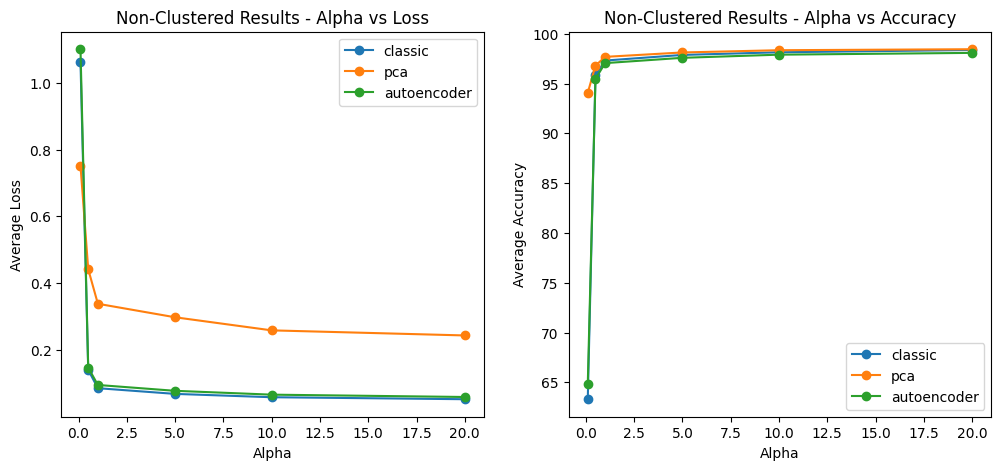


Clustered Results:
classic:
  Average Loss: {0.1: 0.29044288291931153, 0.5: 0.10462678813934326, 1: 0.07538869953155516, 5: 0.06381355056762696, 10: 0.05586019315719604, 20: 0.05132245903015137}
  Average Accuracy: {0.1: 90.7275, 0.5: 96.72500000000001, 1: 97.65, 5: 97.975, 10: 98.2525, 20: 98.395}
pca:
  Average Loss: {0.1: 0.55937759475708, 0.5: 0.38537403030395506, 1: 0.3138889770507812, 5: 0.2804942649841309, 10: 0.2572070163726807, 20: 0.23999321327209472}
  Average Accuracy: {0.1: 95.32000000000001, 0.5: 97.3125, 1: 97.99000000000001, 5: 98.27250000000001, 10: 98.39499999999998, 20: 98.46249999999999}
autoencoder:
  Average Loss: {0.1: 0.24808743934631347, 0.5: 0.11496018829345703, 1: 0.08367300605773925, 5: 0.07195330152511596, 10: 0.06319408864974975, 20: 0.057246300601959225}
  Average Accuracy: {0.1: 92.52, 0.5: 96.54499999999999, 1: 97.41499999999999, 5: 97.7825, 10: 97.9925, 20: 98.16250000000001}


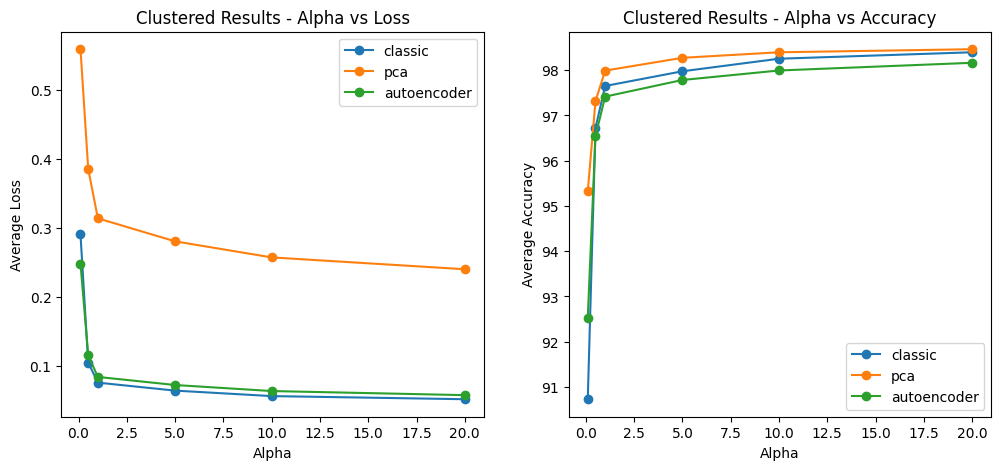

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    
    plt.savefig(filename)
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
